# **🐃🐘 Classificação de Búfalos e Elefantes com Transfer Learning**

📌 Esse projeto usa um modelo pré-treinado (MobileNetV2) pra identificar se uma imagem é de um búfalo ou de um elefante. As imagens foram organizadas em pastas e divididas automaticamente em treino e validação. Foi usado aumento de dados (🔄) pra ajudar o modelo a aprender melhor mesmo com poucas imagens. O objetivo é mostrar como dá pra treinar uma rede neural usando transferência de aprendizado de forma simples e eficiente 🤖✅.


---



📁 **Sessão 1 — Montar Google Drive**

Montar Google Drive para acessar os arquivos.





In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




---


📁 **Sessão 2 — Configurar caminhos e parâmetros**

Definir diretórios de treino e validação.

In [ ]:
# Definir o diretório principal com as classes (bufalo, elefante)
train_dir = '/content/drive/MyDrive/datasets/bufalo_elefante'

# Parâmetros do treino
IMG_SIZE = 160
BATCH_SIZE = 32




---


🧹 **Sessão 3 — Preparar geradores de imagem**

Geradores com aumento de dados para treino e normalização para validação.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Criar ImageDataGenerator com aumento de dados e validation_split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.2  # 20% para validação
)

# Gerador para treino — 80% dos dados, com aumento de dados
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Gerador para validação — 20% dos dados, só normalização
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=True
)




Found 602 images belonging to 2 classes.
Found 150 images belonging to 2 classes.




---


🧠 **Sessão 4 — Criar modelo Transfer Learning**

Aqui usamos o MobileNetV2 pré-treinado e adaptamos a saída para classificar entre búfalo e elefante, aproveitando o que o modelo já aprendeu.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

base_model = MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)



---


🏋️ **Sessão 6 — Compilar e treinar**

Nessa parte, preparamos o modelo para treino definindo o otimizador, a função de perda e as métricas. Depois, rodamos o treino usando os dados de treino e validação para ajustar o modelo.

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 20  # Aumenta o número de épocas

# Compilar o modelo com learning rate menor para treino mais estável
model.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks para controlar o treino
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Treinar o modelo com callbacks
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7901 - loss: 0.4963

19/19 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7905 - loss: 0.4965 - val_accuracy: 0.8333 - val_loss: 0.4972
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8615 - loss: 0.4437

19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8602 - loss: 0.4444 - val_accuracy: 0.8067 - val_loss: 0.4682
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8539 - loss: 0.4310 - val_accuracy: 0.8400 - val_loss: 0.4693
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8346 - loss: 0.4384

19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8358 - loss: 0.4373 - val_accuracy: 0.8667 - val_loss: 0.4287
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8729 - loss: 0.3889

19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.8722 - loss: 0.3892 - val_accuracy: 0.8733 - val_loss: 0.3966
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8732 - loss: 0.3699 - val_accuracy: 0.8933 - val_loss: 0.4048
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8912 - loss: 0.3537

19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8916 - loss: 0.3536 - val_accuracy: 0.8267 - val_loss: 0.3814
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8851 - loss: 0.3630

19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8853 - loss: 0.3627 - val_accuracy: 0.8800 - val_loss: 0.3756
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8815 - loss: 0.3452

19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.8819 - loss: 0.3449 - val_accuracy: 0.8867 - val_loss: 0.3661
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9192 - loss: 0.3365

19/19 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.9192 - loss: 0.3356 - val_accuracy: 0.8800 - val_loss: 0.3597
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9034 - loss: 0.3080

19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9034 - loss: 0.3084 - val_accuracy: 0.9000 - val_loss: 0.3459
Epoch 12/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9224 - loss: 0.2949

19/19 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.9228 - loss: 0.2948 - val_accuracy: 0.8867 - val_loss: 0.3212
Epoch 13/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.9116 - loss: 0.2917 - val_accuracy: 0.8733 - val_loss: 0.3286
Epoch 14/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9307 - loss: 0.2901

19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9303 - loss: 0.2896 - val_accuracy: 0.8667 - val_loss: 0.3144
Epoch 15/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9068 - loss: 0.2908

19/19 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.9070 - loss: 0.2904 - val_accuracy: 0.9200 - val_loss: 0.2873
Epoch 16/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.8915 - loss: 0.2881 - val_accuracy: 0.9000 - val_loss: 0.3177
Epoch 17/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.9171 - loss: 0.2858 - val_accuracy: 0.8733 - val_loss: 0.3146
Epoch 18/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9203 - loss: 0.2658

19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9203 - loss: 0.2662 - val_accuracy: 0.9133 - val_loss: 0.2846
Epoch 19/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9283 - loss: 0.2577

19/19 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.9286 - loss: 0.2573 - val_accuracy: 0.8933 - val_loss: 0.2834
Epoch 20/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9414 - loss: 0.2337 - val_accuracy: 0.9133 - val_loss: 0.2942




---


📊 **Sessão 7 — Avaliar desempenho do modelo**

Aqui verificamos como o modelo está se saindo usando os dados de validação. Também podemos gerar gráficos para mostrar a evolução da acurácia e da perda durante o treino.

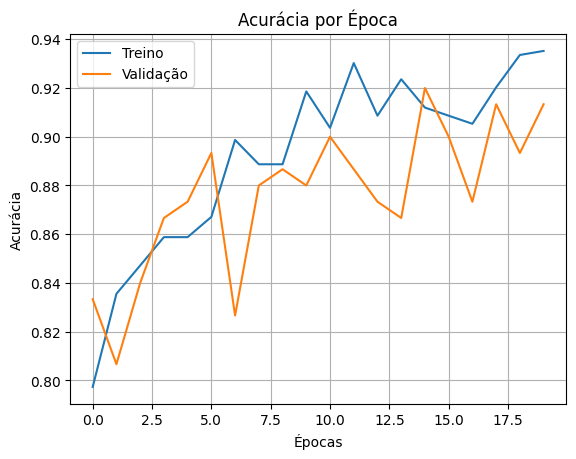

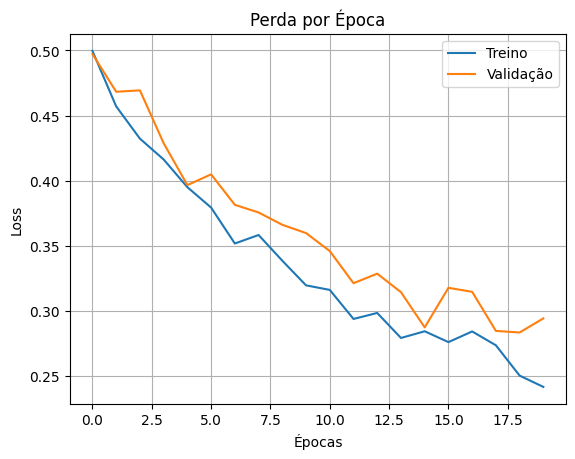

In [ ]:
import matplotlib.pyplot as plt

# Acurácia
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia por Época')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True)
plt.show()

# Perda (loss)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda por Época')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()





---


🔍 **Sessão 8 — Testar predição**

Nesta etapa, usamos imagens novas para ver como o modelo classifica búfalos e elefantes, mostrando a previsão e a confiança para cada imagem.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Predição: Elefante (90.06% de certeza)


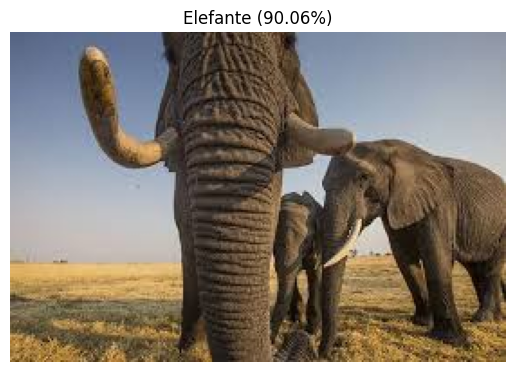

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

def prepare_image(img_path):
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Caminho da imagem a ser testada
img_path = '/content/drive/MyDrive/datasets/teste/10.jpeg'

# Prepara e faz a predição
img_ready = prepare_image(img_path)
pred = model.predict(img_ready)

# Exibe probabilidade
prob = pred[0][0]

# Interpretação do resultado
if prob > 0.5:
    classe = "Elefante"
    prob_formatado = prob * 100
else:
    classe = "Búfalo"
    prob_formatado = (1 - prob) * 100

# Resultado final com porcentagem
print(f"Predição: {classe} ({prob_formatado:.2f}% de certeza)")

# Mostrar a imagem
plt.imshow(image.load_img(img_path))
plt.title(f"{classe} ({prob_formatado:.2f}%)")
plt.axis('off')
plt.show()
